# MNIST Proof (Partial) Side Loop

We need a better lay of the land. Time to examine this sub loss factor more programmatically.

## Imports

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Globals

In [2]:
MODEL_NAME = "./loop-model.pth"

## Set Device to GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [4]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [5]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

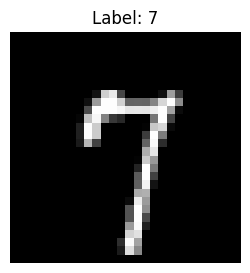

In [6]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [7]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

In [8]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

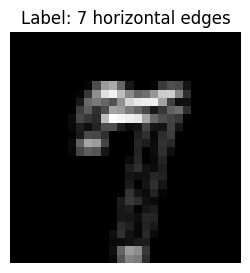

In [9]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [10]:
train_horizontal_image_labels = generate_intermediate_edge_labels(train_images, horizontal_kernel)

In [11]:
val_horizontal_image_labels = generate_intermediate_edge_labels(val_images, horizontal_kernel)

In [12]:
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)

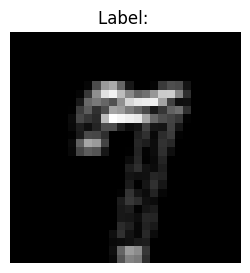

In [13]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [14]:
vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [15]:
vertical_edges = get_edges(vertical_kernel, sample_image)

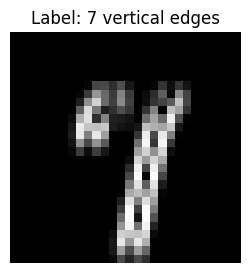

In [16]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [17]:
train_vertical_image_labels = generate_intermediate_edge_labels(train_images, vertical_kernel)

In [18]:
val_vertical_image_labels = generate_intermediate_edge_labels(val_images, vertical_kernel)

In [19]:
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

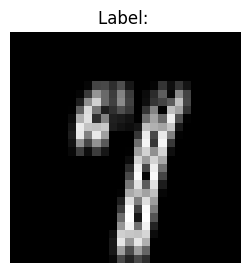

In [20]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

# Our Test

## Architecture

We keep our two hidden layers at image size to be able to calculate a local loss to push those layers to learn human recognizable structures. However, for the example below, we don't calculate intermediate loss, as we need a basis.

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal layer
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical layer connected to horizontal layer
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # detached verision for vertical loss only
        # detached_input = horizontal_act.detach()
        # vertical_out_detached = self.vertical_layer(detached_input)
        # vertical_act_detached = self.activation_function(vertical_out_detached)

        # coupling layer
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act

### Verify Reproducibility

In [22]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [24]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx].copy()).float(),
            torch.from_numpy(self.vertical_edges[idx].copy()).float(),
        )

In [25]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [26]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

In [27]:
steps = [x / 10000 for x in list(range(0, 2000 + 1, 10))]
print(len(steps))
steps

201


[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009,
 0.01,
 0.011,
 0.012,
 0.013,
 0.014,
 0.015,
 0.016,
 0.017,
 0.018,
 0.019,
 0.02,
 0.021,
 0.022,
 0.023,
 0.024,
 0.025,
 0.026,
 0.027,
 0.028,
 0.029,
 0.03,
 0.031,
 0.032,
 0.033,
 0.034,
 0.035,
 0.036,
 0.037,
 0.038,
 0.039,
 0.04,
 0.041,
 0.042,
 0.043,
 0.044,
 0.045,
 0.046,
 0.047,
 0.048,
 0.049,
 0.05,
 0.051,
 0.052,
 0.053,
 0.054,
 0.055,
 0.056,
 0.057,
 0.058,
 0.059,
 0.06,
 0.061,
 0.062,
 0.063,
 0.064,
 0.065,
 0.066,
 0.067,
 0.068,
 0.069,
 0.07,
 0.071,
 0.072,
 0.073,
 0.074,
 0.075,
 0.076,
 0.077,
 0.078,
 0.079,
 0.08,
 0.081,
 0.082,
 0.083,
 0.084,
 0.085,
 0.086,
 0.087,
 0.088,
 0.089,
 0.09,
 0.091,
 0.092,
 0.093,
 0.094,
 0.095,
 0.096,
 0.097,
 0.098,
 0.099,
 0.1,
 0.101,
 0.102,
 0.103,
 0.104,
 0.105,
 0.106,
 0.107,
 0.108,
 0.109,
 0.11,
 0.111,
 0.112,
 0.113,
 0.114,
 0.115,
 0.116,
 0.117,
 0.118,
 0.119,
 0.12,
 0.121,
 0.122,
 0.123,
 0.124,
 0.125,
 0.126,

In [28]:
num_epochs = 20
best_val_loss = float('inf')
runs = dict()
for step in steps:
    # reset the seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
    model = NeuralNetwork().to(device)
    example_w = model.horizontal_layer.weight[0][:5].detach().cpu().numpy()
    print("Model reset:", example_w)

    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    horizontal_loss_fn = nn.MSELoss()
    vertical_loss_fn = nn.MSELoss()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())

    generator = torch.Generator().manual_seed(seed)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)
        
    print(f"Step: {step}")
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        train_loss = 0.0
    
        # train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch in train_loader:
            # deconstruct batch items
            images, labels, horizontal_labels, vertical_labels = batch
            images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
            
            # forward pass
            classification_out, vertical_act, horizontal_act = model(images)
            
            # --- Loss and Backprop ---
    
            # clear gradients
            optimizer.zero_grad()
    
            # vertical loss
            vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)
    
            # horizontal loss
            horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)
    
            # classification loss
            classification_loss = classification_loss_fn(classification_out, labels)
    
            # total loss
            total_loss = step * (vertical_loss + horizontal_loss) + classification_loss
            total_loss.backward()
            
            optimizer.step()
    
            # update progress
            train_loss += total_loss.item()
            # train_bar.set_postfix(loss=classification_loss.item())
    
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        # val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_loader:
                # deconstruct
                images, labels, _, _ = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_horizontal_loss = horizontal_loss / len(train_loader)
        avg_vertical_loss = vertical_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Horizontal Edge Loss: {avg_horizontal_loss:.4f}")
        print(f"  Vertical Edge Loss: {avg_vertical_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    model.eval()  # again currently a no-op
    
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, _, _ = model(images)
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    print("\n---------------------------\n")

    runs[step] = test_accuracy

Model reset: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Step: 0.0
Epoch 1/20
  Train Loss: 0.4910
  Horizontal Edge Loss: 5.5890
  Vertical Edge Loss: 5.2637
  Val Loss: 0.1618 | Val Acc: 95.14%
Epoch 2/20
  Train Loss: 0.1376
  Horizontal Edge Loss: 5.4167
  Vertical Edge Loss: 5.6801
  Val Loss: 0.1809 | Val Acc: 95.13%
Epoch 3/20
  Train Loss: 0.1273
  Horizontal Edge Loss: 6.0522
  Vertical Edge Loss: 5.6561
  Val Loss: 0.1588 | Val Acc: 95.91%
Epoch 4/20
  Train Loss: 0.1135
  Horizontal Edge Loss: 5.5571
  Vertical Edge Loss: 5.6668
  Val Loss: 0.1578 | Val Acc: 96.02%
Epoch 5/20
  Train Loss: 0.1071
  Horizontal Edge Loss: 6.8220
  Vertical Edge Loss: 5.8327
  Val Loss: 0.2001 | Val Acc: 95.95%
Epoch 6/20
  Train Loss: 0.1019
  Horizontal Edge Loss: 6.6694
  Vertical Edge Loss: 6.0035
  Val Loss: 0.1851 | Val Acc: 96.75%
Epoch 7/20
  Train Loss: 0.1002
  Horizontal Edge Loss: 7.1122
  Vertical Edge Loss: 5.4407
  Val Loss: 0.1663 | Val Acc: 96.49%
Epoch 8/20
 

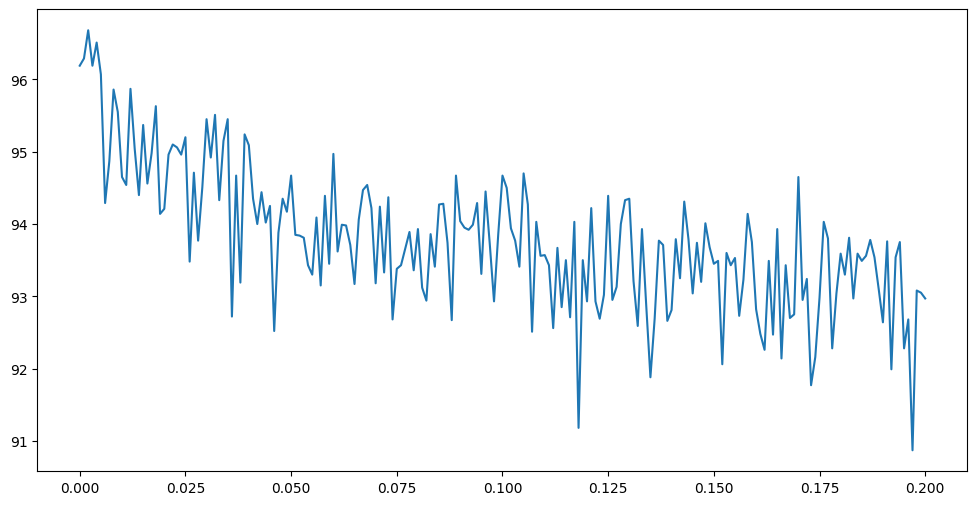

In [29]:
plt.figure(figsize=(12, 6))

x = runs.keys()
y = runs.values()

plt.plot(x, y)
plt.show()

There's a lot of noise here. It is interesting that we can actually improve compared to the unmodified version of the model. Maybe we've achieved a case of wrong method, right solution for our standard.

In [38]:
top_5_runs = sorted(list(runs.items()), key=lambda x: x[1], reverse=True)[:5]
top_5_runs

[(0.002, 96.68), (0.004, 96.51), (0.001, 96.29), (0.0, 96.19), (0.003, 96.19)]